Mike Leske  
R00183658

# Question1_3

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.utils import np_utils
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

2.2.0-rc2


Using TensorFlow backend.


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the training and test data
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

# reshape the feature data
train_x = train_x.reshape(train_x.shape[0], 784)
test_x = test_x.reshape(test_x.shape[0], 784)

# normalize feature data
train_x = train_x / 255.0
test_x = test_x / 255.0

print("Shape of training features", train_x.shape)
print("Shape of test features", test_x.shape)

# one hot encode the training labels and get the transpose
train_y = np_utils.to_categorical(train_y, 10)
train_y = train_y.T
print("Shape of the training labels", train_y.shape)

# one hot encode the test labels and get the transpose
test_y = np_utils.to_categorical(test_y, 10)
test_y = test_y.T
print("Shape of the training labels", test_y.shape)

4423680/4422102 [==============================] - 0s 0us/step
Shape of training features (60000, 784)
Shape of test features (10000, 784)
Shape of the training labels (10, 60000)
Shape of the training labels (10, 10000)


In [ ]:
@tf.function
def forward_pass(x, w1, b1, w2, b2, w3, b3):
    # Hidden layer 1
    h1 = tf.add(tf.matmul(tf.cast(x, dtype=tf.float32), tf.cast(w1, dtype=tf.float32)), b1)
    a1 = tf.maximum(h1, 0)

    # Hidden layer 2
    h2 = tf.add(tf.matmul(tf.cast(a1, dtype=tf.float32), tf.cast(w2, dtype=tf.float32)), b2)
    a2 = tf.maximum(h2, 0)

    # Softmax layer
    logits = tf.add(tf.matmul(tf.cast(a2, dtype=tf.float32), tf.cast(w3, dtype=tf.float32)), b3)
    softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis=-1, keepdims=True)
    
    return softmax

@tf.function
def cross_entropy(y_pred, y, weights=[], l1=None, l2=None):
    # Transpose y_pred to allow multiplication
    # Calculate Cross-Entropy Loss per instance
    # Calculate total loss
    y_pred = tf.transpose(y_pred)
    ce = -tf.reduce_sum(y * tf.math.log(y_pred), axis=0)
    loss = tf.reduce_mean(ce)

    # Implement regularization
    # Solution allows to have L1 and L2 regularization in parralel
    reg = 0
    if l1:
        # Implement L1 regularization
        #   1. Sum up the absolute weights of the weight matrices
        #   2. Multiply summed weight with L1 regularization scale parameter
        weights_sum = tf.reduce_sum([ tf.reduce_sum(tf.abs(w)) for w in weights ])
        reg += tf.multiply(tf.constant(l1, dtype=tf.float32), weights_sum)
    
    if l2:
        # Implement L2 regularization
        #   1. Sum up the squared weights of the weight matrices
        #   2. Multiply summed weight with L2 regularization scale parameter
        weights_sum = tf.reduce_sum([ tf.reduce_sum(tf.square(w)) for w in weights ])
        reg += tf.multiply(tf.constant(l2, dtype=tf.float32), weights_sum)
    
    # Create separate reg_loss term for later visualization
    reg_loss = loss + reg

    return loss, reg_loss

@tf.function
def calculate_accuracy(y_pred, y):
    # Take the transpose of y_pred to bring y_pred and y into same shape
    # Create vector with 1.0 if prediction and y have highest probability for same class, 0.0 otherwise
    # Caluculate average of that vector to get accuracy
    predictions = tf.transpose(y_pred)
    predictions_correct = tf.cast(tf.equal(tf.argmax(predictions, axis=0), tf.argmax(y, axis=0)), tf.float32)
    accuracy = tf.reduce_mean(predictions_correct)
    return accuracy

def plot_loss(epochs):
    plt.plot(np.arange(0, epochs), history['loss'], label="train_loss")
    plt.plot(np.arange(0, epochs), history['reg_loss'], label="reg_loss")
    plt.plot(np.arange(0, epochs), history['acc'], label="train_acc")
    plt.title("Training Acc/Loss - 1_3")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_weights(epochs):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle('Weights changes during training', fontsize=16)

    ax1.plot(np.arange(0, epochs), history['weights_sum'], label="weights_sum")
    ax1.set_title("Sum of Weights")
    ax1.set_xlabel('Epoch #')
    ax1.set_ylabel('Weights Total')
    
    ax2.plot(np.arange(0, epochs), history['weights_max'], label="weights_max")
    ax2.set_title("Max Weight")
    ax2.set_xlabel('Epoch #')
    ax2.set_ylabel('Weights Max')

    ax3.plot(np.arange(0, epochs), history['weights_avg'], label="weights_avg")
    ax3.set_title("Avg Weight")
    ax3.set_xlabel('Epoch #')
    ax3.set_ylabel('Weights Avg')

    #plt.tight_layout()

def optimize(epochs, optimizer, layers, l1=None, l2=None):
    input_size = train_x.shape[1]
    num_classes = 10

    #
    # Initialize weights and biases for 3 layers
    #
    w1 = tf.Variable(tf.random.normal([input_size, layers[0]], mean=0.0, stddev=0.05))
    b1 = tf.Variable(tf.zeros([1, layers[0]]))

    w2 = tf.Variable(tf.random.normal([layers[0], layers[1]], mean=0.0, stddev=0.05))
    b2 = tf.Variable(tf.zeros([1, layers[1]]))

    w3 = tf.Variable(tf.random.normal([layers[1], num_classes], mean=0.0, stddev=0.05))
    b3 = tf.Variable(tf.zeros([1, num_classes]))

    weights = [ w1, w2, w3 ]
    biases  = [ b1, b2, b3 ]

    #
    # Iterate through epochs
    #
    for i in range(epochs):
        with tf.GradientTape() as tape:
            #
            # Execute 1 training cycle with L1, L2 regularization 
            # or without regularization
            #
            y_pred = forward_pass(train_x, w1, b1, w2, b2, w3, b3)
            loss, reg_loss = cross_entropy(y_pred, train_y, weights, l1, l2)
            
            #
            # Add epoch accuracy and loss to history
            #
            history['acc'].append(calculate_accuracy(y_pred, train_y))
            history['loss'].append(loss)
            history['reg_loss'].append(reg_loss)
        
        #
        # Caluclate the gradients for weights and biases 
        # Update weights and biases
        #
        gradients = tape.gradient(reg_loss, weights + biases)
        optimizer.apply_gradients(zip(gradients, weights + biases))

        #
        # Track weights metrics for visualization
        #
        history['weights_sum'].append( sum([ tf.reduce_sum(w) for w in weights ]) )
        history['weights_max'].append( max([ tf.reduce_max(w) for w in weights ]) )
        history['weights_avg'].append( sum([ tf.reduce_mean(w) for w in weights ]) / 3 )

    #
    # Print final training accuracy and regularized loss
    #
    print('The train accuracy is:', history['acc'][-1].numpy())
    print('The train loss     is:', history['reg_loss'][-1].numpy())

    #
    # Calculate predictions and loss for test set
    #
    y_pred = forward_pass(test_x, w1, b1, w2, b2, w3, b3)
    loss, reg_loss = cross_entropy(y_pred, test_y, weights, l1, l2)

    #
    # Calculate test set accuracy and print accuracy + loss
    #
    accuracy = calculate_accuracy(y_pred, test_y)
    print('The test accuracy is:', accuracy.numpy())
    print('The test loss     is:', reg_loss.numpy(), '\n')

    plot_loss(epochs)
    plot_weights(epochs)

---

### Train network architecture B with L1 regularization

The train accuracy is: 0.8344
The train loss     is: 1.118602
The test accuracy is: 0.8225
The test loss     is: 1.1372268 



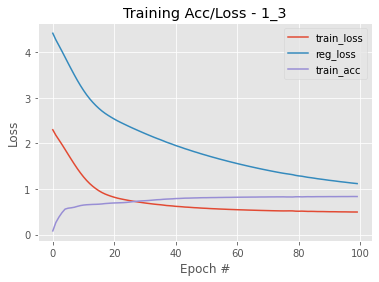

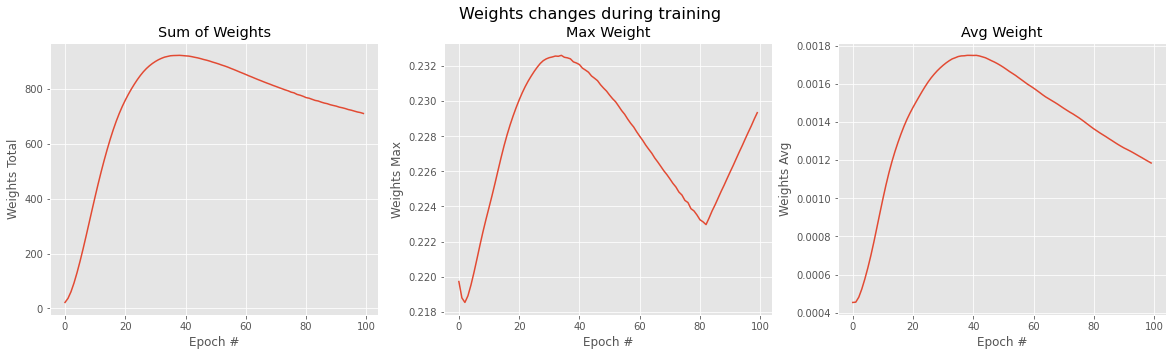

In [17]:
history = {
    'acc': [],
    'loss': [],
    'reg_loss': [],
    'weights_sum': [],
    'weights_max': [],
    'weights_avg': [],
}

epochs = 100
layers = [300, 100]
l1 = 0.0002
opt = tf.keras.optimizers.Adam()

optimize(epochs, opt, layers, l1=l1)

---

### Train network architecture B with L2 regularization

The train accuracy is: 0.84928334
The train loss     is: 0.7882097
The test accuracy is: 0.8384
The test loss     is: 0.811764 



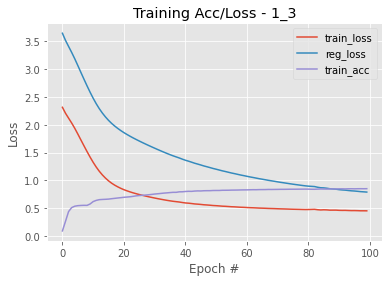

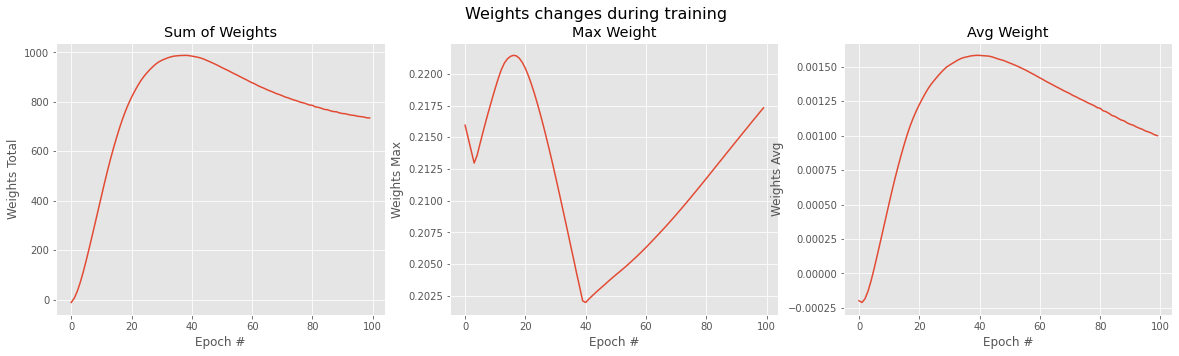

In [18]:
history = {
    'acc': [],
    'loss': [],
    'reg_loss': [],
    'weights_sum': [],
    'weights_max': [],
    'weights_avg': [],
}

epochs = 100
layers = [300, 100]
l2 = 0.002
opt = tf.keras.optimizers.Adam()

optimize(epochs, opt, layers, l2=l2)

---

### Train network architecture B with no regularization

The train accuracy is: 0.8614
The train loss     is: 0.39898965
The test accuracy is: 0.8476
The test loss     is: 0.43574893 



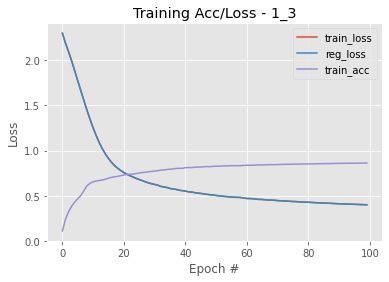

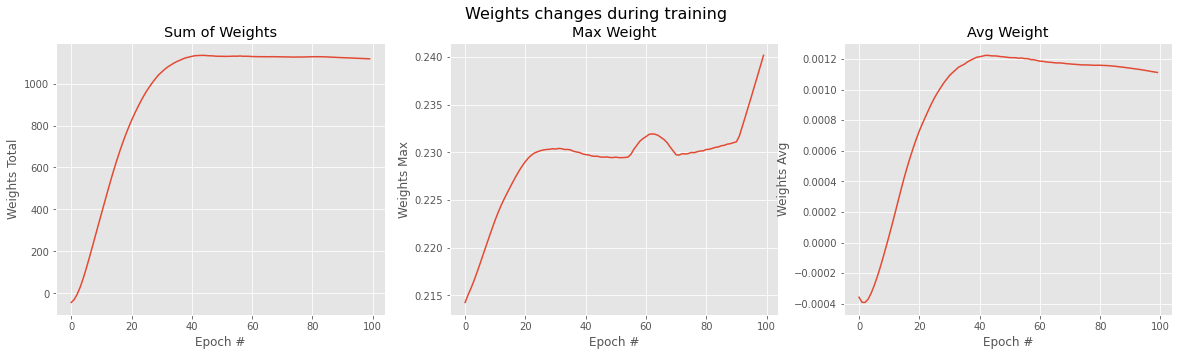

In [19]:
history = {
    'acc': [],
    'loss': [],
    'reg_loss': [],
    'weights_sum': [],
    'weights_max': [],
    'weights_avg': [],
}

epochs = 100
layers = [300, 100]
opt = tf.keras.optimizers.Adam()

optimize(epochs, opt, layers)